Download data van ENTSO-E

In [16]:
import pandas as pd
from entsoe import EntsoePandasClient
import time

# Insert your API key here once you get it
API_KEY = '82aa28d4-59f3-4e3a-b144-6659aa9415b5'

# Initialize ENTSO-E client
client = EntsoePandasClient(api_key=API_KEY)

# Define parameters
country_code = 'NL'
neighboring_countries = ['BE', 'DE', 'GB', 'DK', 'NO']  # Pas dit aan op basis van de relevante buren
years = [2022, 2023, 2024,2025]  # List of years to fetch

# Data storage
all_data = []

# Function to fetch data with retries
def fetch_with_retries(fetch_func, *args, retries=3, delay=5, **kwargs):
    for attempt in range(retries):
        try:
            return fetch_func(*args, **kwargs)
        except Exception as e:
            print(f"Error: {e}, retrying in {delay} seconds...")
            time.sleep(delay)
    raise Exception(f"Failed to fetch data after {retries} attempts")

# Loop through each year and fetch data separately
for year in years:
    start = pd.Timestamp(f'{year}-01-01', tz='Europe/Amsterdam')
    end = pd.Timestamp(f'{year+1}-01-01', tz='Europe/Amsterdam')  # Exclusive end

    print(f"Fetching load data for {year}...")
    yearly_load = fetch_with_retries(client.query_load, country_code, start=start, end=end).squeeze()  # Convert to 1D Series

    print(f"Fetching load forecast for {year}...")
    yearly_load_forecast = fetch_with_retries(client.query_load_forecast, country_code, start=start, end=end).squeeze()  # Convert to 1D Series

    print(f"Fetching price data for {year}...")
    yearly_price = fetch_with_retries(client.query_day_ahead_prices, country_code, start=start, end=end).squeeze()  # Convert to 1D Series

    # Fetch cross-border flows
    flow_data = {}
    for neighbor in neighboring_countries:
        print(f"Fetching cross-border flow from {neighbor} to {country_code} for {year}...")
        yearly_flow_to = fetch_with_retries(client.query_crossborder_flows, country_code_from=neighbor, 
                                            country_code_to=country_code, start=start, end=end).squeeze()  # Convert to 1D Series
        flow_data[f'Flow_{neighbor}_to_{country_code}'] = yearly_flow_to

        print(f"Fetching cross-border flow from {country_code} to {neighbor} for {year}...")
        yearly_flow_from = fetch_with_retries(client.query_crossborder_flows, country_code_from=country_code, 
                                              country_code_to=neighbor, start=start, end=end).squeeze()  # Convert to 1D Series
        flow_data[f'Flow_{country_code}_to_{neighbor}'] = yearly_flow_from

    # Merge all data
    if not yearly_load.empty and not yearly_price.empty:
        df = pd.DataFrame({'Load': yearly_load, 'Price': yearly_price})
        for col_name, flow_series in flow_data.items():
            if not flow_series.empty:
                df[col_name] = flow_series

        # Store yearly data
        all_data.append(df)
    else:
        print(f"No data for year {year}")

# Concatenate all years into one DataFrame if there is data
if all_data:
    final_data = pd.concat(all_data)
    # Save to CSV
    final_data.to_csv('electricity_data_nl_2022_2025.csv')
    print("Data saved successfully!")
else:
    print("No data to save.")

Fetching load data for 2022...
Fetching load forecast for 2022...
Fetching price data for 2022...
Fetching cross-border flow from BE to NL for 2022...
Fetching cross-border flow from NL to BE for 2022...
Fetching cross-border flow from DE to NL for 2022...
Fetching cross-border flow from NL to DE for 2022...
Fetching cross-border flow from GB to NL for 2022...
Fetching cross-border flow from NL to GB for 2022...
Fetching cross-border flow from DK to NL for 2022...
Fetching cross-border flow from NL to DK for 2022...
Fetching cross-border flow from NO to NL for 2022...
Fetching cross-border flow from NL to NO for 2022...
Fetching load data for 2023...
Fetching load forecast for 2023...
Fetching price data for 2023...
Fetching cross-border flow from BE to NL for 2023...
Fetching cross-border flow from NL to BE for 2023...
Fetching cross-border flow from DE to NL for 2023...
Fetching cross-border flow from NL to DE for 2023...
Fetching cross-border flow from GB to NL for 2023...
Fetching 

Connection Error, retrying in 0 seconds


Fetching load data for 2024...
Error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), retrying in 5 seconds...
Fetching load forecast for 2024...
Fetching price data for 2024...
Fetching cross-border flow from BE to NL for 2024...
Fetching cross-border flow from NL to BE for 2024...
Fetching cross-border flow from DE to NL for 2024...
Fetching cross-border flow from NL to DE for 2024...
Fetching cross-border flow from GB to NL for 2024...
Fetching cross-border flow from NL to GB for 2024...
Fetching cross-border flow from DK to NL for 2024...
Fetching cross-border flow from NL to DK for 2024...
Fetching cross-border flow from NO to NL for 2024...
Fetching cross-border flow from NL to NO for 2024...
Fetching load data for 2025...


Connection Error, retrying in 0 seconds


Error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), retrying in 5 seconds...
Fetching load forecast for 2025...
Fetching price data for 2025...
Fetching cross-border flow from BE to NL for 2025...
Fetching cross-border flow from NL to BE for 2025...
Fetching cross-border flow from DE to NL for 2025...


Connection Error, retrying in 0 seconds


Fetching cross-border flow from NL to DE for 2025...
Error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), retrying in 5 seconds...
Fetching cross-border flow from GB to NL for 2025...
Fetching cross-border flow from NL to GB for 2025...
Fetching cross-border flow from DK to NL for 2025...
Fetching cross-border flow from NL to DK for 2025...
Fetching cross-border flow from NO to NL for 2025...
Fetching cross-border flow from NL to NO for 2025...
Data saved successfully!


C:\Users\shba\AppData\Local\Temp\ipykernel_11672\2787946273.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 7)  # Use a colormap with 7 distinct colors


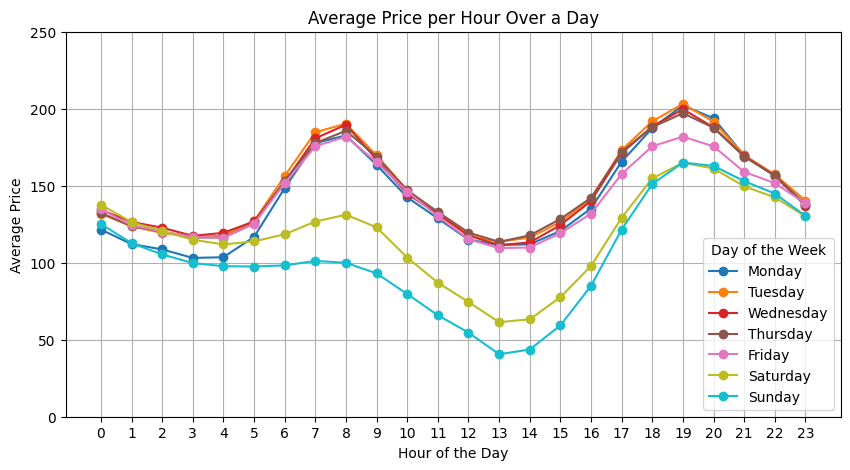

In [11]:
import matplotlib.pyplot as plt


# Drop rows with missing values in 'Price' column
df_filtered_price = final_data[['Price']].dropna()

# Extract the hour and day of the week from the index
df_filtered_price['Hour'] = df_filtered_price.index.hour
df_filtered_price['DayOfWeek'] = df_filtered_price.index.dayofweek

# Define a color map for the days of the week
colors = plt.cm.get_cmap('tab10', 7)  # Use a colormap with 7 distinct colors

# Plot the average price per hour for each day of the week
plt.figure(figsize=(10, 5))
for day in range(7):
    day_data = df_filtered_price[df_filtered_price['DayOfWeek'] == day]
    average_price_per_hour = day_data.groupby('Hour')['Price'].mean()
    plt.plot(average_price_per_hour.index, average_price_per_hour, marker='o', linestyle='-', color=colors(day), label=f'Day {day}')

plt.xlabel('Hour of the Day')
plt.ylabel('Average Price')
plt.title('Average Price per Hour Over a Day')
plt.xticks(range(24))  # Ensure all hours are shown on the x-axis
plt.grid(True)
plt.legend(title='Day of the Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylim(0, 250)
plt.show()

Read excel file + data per uur

In [19]:
import pandas as pd
from entsoe import EntsoePandasClient
import time


    # Load the existing CSV file
df = pd.read_csv('electricity_data_nl_2022_2025.csv', index_col=0, parse_dates=True)
print("CSV file loaded successfully!")

# Ensure the index is datetime with UTC
df.index = pd.to_datetime(df.index, utc=True)
print("Index converted to datetime with UTC!")

# Shift timestamps by 1 hour to calculate the mean for the past hour
df.index = df.index - pd.Timedelta(hours=1)

# Resample the data to hourly frequency and calculate the mean for each hour
df_hourly = df.resample('h').mean()
print("Data resampled to hourly frequency based on the past hour!")

# Save the resampled data to a new CSV file
df_hourly.to_csv('electricity_data_nl_2022_2025_hourly.csv')
print("Hourly data with flow saved successfully!")



CSV file loaded successfully!
Index converted to datetime with UTC!
Data resampled to hourly frequency based on the past hour!
Hourly data with flow saved successfully!


In [ ]:
#Nieuwe variabelen flow toevoegen (per land en totaal)

In [20]:
neighboring_countries = ['BE', 'DE', 'GB', 'DK', 'NO']

for neighbor in neighboring_countries:
    df_hourly[f'Flow_{neighbor}'] = df_hourly[f'Flow_{neighbor}_to_NL'] - df_hourly[f'Flow_NL_to_{neighbor}']

df_hourly['Total_Flow'] = df_hourly['Flow_BE'] + df_hourly['Flow_DE'] + df_hourly['Flow_GB'] + df_hourly['Flow_DK'] + df_hourly['Flow_DK']
df_hourly.to_csv('electricity_data_nl_2022_2025_hourly_flow.csv')


In [21]:
# Generate a concise summary of the dataset
def summary(df):
    print("Dataset Summary:")
    print(df.describe(include='all'))  # Summary statistics
    print("\nMissing Values (NA) per Column:")
    print(df.isna().sum())  # Count of missing values

summary(df_hourly)

Dataset Summary:
               Load         Price  Flow_BE_to_NL  Flow_NL_to_BE  \
count  28785.000000  28796.000000   28785.000000   28785.000000   
mean   12390.885699    135.447528     228.750703     830.193121   
std     2251.747207    109.578034     476.233496     843.298175   
min      138.750000   -500.000000       0.000000       0.000000   
25%    10837.000000     76.500000       0.000000       0.000000   
50%    12240.750000    106.445000       0.000000     625.000000   
75%    13762.000000    166.145000     188.000000    1432.000000   
max    19483.250000    872.960000    3709.000000    4181.000000   

       Flow_DE_to_NL  Flow_NL_to_DE  Flow_GB_to_NL  Flow_NL_to_GB  \
count   28784.000000   28784.000000   28783.000000   28783.000000   
mean      801.725817     983.325131     196.001372     424.783176   
std       771.633465    1041.889069     341.327009     443.067501   
min         0.000000       0.000000       0.000000       0.000000   
25%        52.250000       9.75000

In [22]:
# Find timestamps with NA values for each column
def list_na_timestamps(df):
    na_timestamps = {}
    for column in df.columns:
        na_timestamps[column] = df[df[column].isna()].index.tolist()
    return na_timestamps

# Generate the list of NA timestamps
na_timestamps = list_na_timestamps(df_hourly)

# Print the NA timestamps for each variable
for column, timestamps in na_timestamps.items():
    print(f"Variable: {column}")
    print(f"NA Timestamps: {timestamps[:50]}")  # Print first 10 timestamps for brevity
    print(f"Total NA Count: {len(timestamps)}\n")

Variable: Load
NA Timestamps: [Timestamp('2025-04-14 07:00:00+0000', tz='UTC'), Timestamp('2025-04-14 08:00:00+0000', tz='UTC'), Timestamp('2025-04-14 09:00:00+0000', tz='UTC'), Timestamp('2025-04-14 10:00:00+0000', tz='UTC'), Timestamp('2025-04-14 11:00:00+0000', tz='UTC'), Timestamp('2025-04-14 12:00:00+0000', tz='UTC'), Timestamp('2025-04-14 13:00:00+0000', tz='UTC'), Timestamp('2025-04-14 14:00:00+0000', tz='UTC'), Timestamp('2025-04-14 15:00:00+0000', tz='UTC'), Timestamp('2025-04-14 16:00:00+0000', tz='UTC'), Timestamp('2025-04-14 17:00:00+0000', tz='UTC'), Timestamp('2025-04-14 18:00:00+0000', tz='UTC'), Timestamp('2025-04-14 19:00:00+0000', tz='UTC'), Timestamp('2025-04-14 20:00:00+0000', tz='UTC')]
Total NA Count: 14

Variable: Price
NA Timestamps: [Timestamp('2022-12-30 22:00:00+0000', tz='UTC'), Timestamp('2023-12-30 22:00:00+0000', tz='UTC'), Timestamp('2024-12-30 22:00:00+0000', tz='UTC')]
Total NA Count: 3

Variable: Flow_BE_to_NL
NA Timestamps: [Timestamp('2025-04-14 07: